In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd , tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=13, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.2
pandas 1.1.5
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [13]:
!nvidia-smi

Wed Dec  1 10:52:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.84       Driver Version: 460.84       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   27C    P8    29W / 350W |   1932MiB / 24267MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# 1. loads data
# 2. preprocesses data -> dataset
# 3. tools
# 3.1 generates position embedding
# 3.2 create mask. (a. padding, b. decoder)
# 3.3 scaled_dot_product_attention
# 4. builds model 分为以下6步
    # 4.1 MultiheadAttention
    # 4.2 EncoderLayer
    # 4.3 DecoderLayer
    # 4.4 EncoderModel
    # 4.5 DecoderModel
    # 4.6 Transformer
# 5. optimizer & loss
# 6. train step -> train
# 7. Evaluate and Visualize

In [15]:
import tensorflow_datasets as tfds
#葡萄牙语到英语，这个是基于subword的
examples, info = tfds.load('ted_hrlr_translate/pt_to_en',
                           with_info = True,
                           as_supervised = True)

train_examples, val_examples = examples['train'], examples['validation']
print(info)#info里是数据集的描述

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=0.0.1,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    urls=['https://github.com/neulab/word-embeddings-for-nmt'],
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)



In [16]:
#葡萄牙语中有一些特除的字符，用转义字符来打印
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()
print(train_examples)

b'aterrei pela primeira vez em roma , it\xc3\xa1lia .'
b'i landed for the first time in rome , italy .'

b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'
b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them ."

b'houve alega\xc3\xa7\xc3\xb5es de intimida\xc3\xa7\xc3\xa3o nas mesas de voto , de urnas de voto serem roubadas .'
b'there were claims of intimidation at the polling stations , of ballot boxes being stolen .'

b'lembrem-se do que resgatou os desfavorecidos .'
b'remember what pulled up the poor .'

b'o problema \xc3\xa9 que nunca vivi l\xc3\xa1 um \xc3\xbanico dia .'
b"except , i 've never lived one day of my life there ."

<_OptionsDataset 

In [17]:
#这里运行要点时间
#我们自己转为subword数据集，2**13是8192，build_from_corpus
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size = 2 ** 13)


In [18]:
#测试一个字符串,subword里边是包含空格的
sample_string = "Transformer is awesome."

tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print('The original string is {}'.format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"-->{}'.format(token, en_tokenizer.decode([token]),len(en_tokenizer.decode([token]))))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is Transformer is awesome.
7915 --> "T"-->1
1248 --> "ran"-->3
7946 --> "s"-->1
7194 --> "former "-->7
13 --> "is "-->3
2799 --> "awesome"-->7
7877 --> "."-->1


In [19]:
pt_tokenizer.vocab_size

8214

In [20]:
en_tokenizer.vocab_size

8087

In [21]:
buffer_size = 20000
batch_size = 64
max_length = 40  #输入和输出的最大长度是40

#把两段文本转为subword形式，
def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence

#用tf的API消去大于最大长度的
def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)
#用py_function封装一下encode_to_subword
def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [pt_sentence, en_sentence],
                          [tf.int64, tf.int64])
#把所有句子变为subword，subword都变为id
train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
#接着做洗牌，padding，batch -1，-1代表两个维度，每个维度都在当前维度下扩展到最高的值
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))
    

In [22]:
for pt_batch, en_batch in train_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 40) (64, 39)
(64, 39) (64, 37)
(64, 40) (64, 38)
(64, 39) (64, 36)
(64, 40) (64, 39)


In [23]:
#第三步，写一些工具函数
# PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

#pos 和i都是矩阵
# pos.shape: [sentence_length, 1]
# i.shape  : [1, d_model]
# result.shape: [sentence_length, d_model]
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000,
                               (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

#计算位置信息
def get_position_embedding(sentence_length, d_model):
    #sentence_length和d_model都扩展为矩阵
#     print(np.arange(sentence_length)[:, np.newaxis])
#     print(np.arange(d_model)[np.newaxis, :])
    #pos是0到49，就是词的位置，i是从0到511，总计512，和dim相等
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    print(angle_rads.shape)
    # sines.shape: [sentence_length, d_model / 2]
    # cosines.shape: [sentence_length, d_model / 2]
    print(angle_rads[:, 0::2].shape)
    print(angle_rads[:, 1::2].shape)
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    
    #把sines和cosines进行拼接
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    #进行维度扩展
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]
    #变为float32类型
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(50, 512)
print(position_embedding)

(50, 512)
(50, 256)
(50, 256)
tf.Tensor(
[[[ 0.          0.          0.         ...  1.          1.
    1.        ]
  [ 0.84147096  0.8218562   0.8019618  ...  1.          1.
    1.        ]
  [ 0.9092974   0.9364147   0.95814437 ...  1.          1.
    1.        ]
  ...
  [ 0.12357312  0.97718984 -0.24295525 ...  0.9999863   0.99998724
    0.99998814]
  [-0.76825464  0.7312359   0.63279754 ...  0.9999857   0.9999867
    0.9999876 ]
  [-0.95375264 -0.14402692  0.99899054 ...  0.9999851   0.9999861
    0.9999871 ]]], shape=(1, 50, 512), dtype=float32)


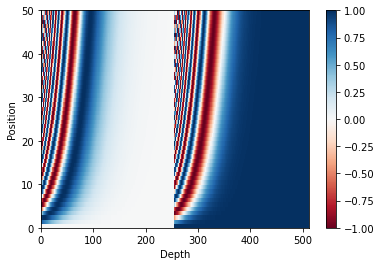

In [24]:
#这个图和我们原理中展示的横纵坐标是颠倒的
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap = 'RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()
    
plot_position_embedding(position_embedding)

In [25]:
#如何生成mask
# 1. padding mask, 2. look ahead

# batch_data.shape: [batch_size, seq_len]
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, seq_len]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]
#设置3x5矩阵，0都是padding，是零的得到的都是1，其他的都是零
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [26]:
# attention_weights.shape: [3,3]
#第一个位置代表第一个单词和自己的attention，第二位置是第二个单词和第一个单词的attention
#看不到后面的词刚好是下三角，使用库函数来实现
# [[1, 0, 0],
#  [4, 5, 0],
#  [7, 8, 9]]
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (seq_len, seq_len)

#前面看不到后面的padding，矩阵下面全部为0
# 在mask里，应该被忽略的我们会设成1，应该被保留的会设成0，
# 而如果mask相应位置上为1，那么我们就给对应的logits 
# 加上一个超级小的负数， -1000000000， 这样，
# 对应的logits也就变成了一个超级小的数。然后在计算softmax的时候，
# 一个超级小的数的指数会无限接近与0。也就是它对应的attention的权重就是0了,
# 下面可以看到
create_look_ahead_mask(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [27]:
#参考原理文档，q是query，k，v代表k和value，q和k做完矩阵乘法后，做mask
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v  这两个是相等的
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    #计算attentions时，我们只用了后两维在计算
    # transpose_b代表第二个矩阵是否做转置
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b = True)
    
    #获得dk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    #然后根据文档中的公式除以dk
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    #如果mask不是空的话，给scaled_attention_logits加一个mask（缩放）
    if mask is not None:
        # 使得在softmax后值趋近于0
        scaled_attention_logits += (mask * -1e9)
    
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis = -1)
    
    #根据原理图，v和attention_weights进行矩阵乘法
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

#调用上面的函数，去验证
def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights are:")
    print(temp_att)
    print("Output is:")
    print(temp_out)
    

In [28]:
#我们定义一个测试的Q，K，V
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32) # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)

temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)
#可以把这句注释，它的作用是做四舍五入，让结果清爽
np.set_printoptions(suppress=True)

print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [29]:
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32) # (1, 3)
#0.  0.  0.5 0.5 会和temp_v去做平均，因此得到的是550,5.5
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [30]:
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [31]:
#拼起来再来测试
temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0]], dtype=tf.float32) # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [32]:
#多头注意力的实现
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上:
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    
    实战中:把三个概念区分开
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    
    实战中技巧：q乘以W得到一个大的Q，然后分割为多个小q
    q -> Wq -> Q -> split -> q0, q1, q2...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        #这里对应的大Q变小q怎么变，层次
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        #这里是拼接
        self.dense = keras.layers.Dense(self.d_model)
    
    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        #把x变为下面维度，用reshape
        # x -> (batch_size, num_heads, seq_len, depth)
        
        x = tf.reshape(x,
                       (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])#轴滚动
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        #经过Q K V变化
        print(q.shape)
        q = self.WQ(q) # q.shape: (batch_size, seq_len_q, d_model)
        k = self.WK(k) # k.shape: (batch_size, seq_len_k, d_model)
        v = self.WV(v) # v.shape: (batch_size, seq_len_v, d_model)
        print('-'*50)
        print(q.shape)
        # q.shape: (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)
        
        #开始做缩放点积，得到的多头的信息存在在num_heads，depth上
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        
        #因此这里做一下转置，让num_heads，depth在后面
        # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm = [0, 2, 1, 3])
        
        #对注意力进行合并
        # concat_attention.shape: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs,
                                      (batch_size, -1, self.d_model))
        
        #多头注意力计算完毕
        # output.shape : (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights
    
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
#创建一份虚拟数据
y = tf.random.uniform((1, 60, 256)) # (batch_size, seq_len_q, dim)
#开始计算，把y既当q，又当k，v
output, attn = temp_mha(y, y, y, mask = None)
print(output.shape)
print(attn.shape)

(1, 60, 256)
--------------------------------------------------
(1, 60, 512)
(1, 60, 512)
(1, 8, 60, 60)


In [33]:
#定义我们的feed_forward_network，d_model节点数
def feed_forward_network(d_model, dff):
    # dff: dim of feed forward network.
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512, 2048)
#给一个输入测试
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [34]:
#自定义EncoderLayer
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feed_forward -> add & normalize & dropout
    原理对应文档Add & Normalize 标题下的图
    """
    #d_model 给self attention和feed_forward_network，num_heads给self_attention用的
    #dff给feed_forward_network，rate是做dropout的
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        # epsilon 将小浮点数添加到方差以避免被零除
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        #下面两个层次用了做dropout，每次有10%的几率被drop掉
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape          : (batch_size, seq_len, dim=d_model)
        # attn_output.shape: (batch_size, seq_len, d_model)
        # out1.shape       : (batch_size, seq_len, d_model)
        #x作为q，k，v  原理对应文档Add & Normalize 标题下的图
        attn_output, _ = self.mha(x, x, x, encoder_padding_mask)
        attn_output = self.dropout1(attn_output, training=training)
        #dim=d_model 两个必须相等，这样x才可以和attn_output做加法
        out1 = self.layer_norm1(x + attn_output)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        # out2.shape      : (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norm2(out1 + ffn_output)
        
        return out2
#来测试，结果和我们最初的输入维度一致，相当于做了两次残差连接
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)
--------------------------------------------------
(64, 50, 512)
(64, 50, 512)


In [35]:
sample_encoder_layer.variables

[<tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/kernel:0' shape=(512, 512) dtype=float32, numpy=
 array([[-0.06375826, -0.06400497,  0.05346561, ..., -0.05691981,
         -0.04647036,  0.00539462],
        [-0.05929273, -0.04325018,  0.06238494, ..., -0.01568025,
         -0.07140822, -0.00790648],
        [-0.00829075, -0.0028923 , -0.00834498, ..., -0.02490101,
          0.05247945, -0.01541715],
        ...,
        [-0.00755053, -0.03498329,  0.02771617, ..., -0.05648112,
         -0.06326326,  0.00368494],
        [ 0.02549014,  0.05162101, -0.05393816, ...,  0.01787171,
         -0.02584456, -0.05261625],
        [ 0.03859899,  0.0114012 , -0.01101557, ..., -0.02293916,
          0.04842018,  0.07185272]], dtype=float32)>,
 <tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [36]:
sample_encoder_layer.trainable_variables

[<tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/kernel:0' shape=(512, 512) dtype=float32, numpy=
 array([[-0.06375826, -0.06400497,  0.05346561, ..., -0.05691981,
         -0.04647036,  0.00539462],
        [-0.05929273, -0.04325018,  0.06238494, ..., -0.01568025,
         -0.07140822, -0.00790648],
        [-0.00829075, -0.0028923 , -0.00834498, ..., -0.02490101,
          0.05247945, -0.01541715],
        ...,
        [-0.00755053, -0.03498329,  0.02771617, ..., -0.05648112,
         -0.06326326,  0.00368494],
        [ 0.02549014,  0.05162101, -0.05393816, ...,  0.01787171,
         -0.02584456, -0.05261625],
        [ 0.03859899,  0.0114012 , -0.01101557, ..., -0.02293916,
          0.04842018,  0.07185272]], dtype=float32)>,
 <tf.Variable 'encoder_layer/multi_head_attention_1/dense_6/bias:0' shape=(512,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [37]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout -> out1
    out1 , encoding_outputs -> attention -> add & normalize & dropout -> out2
    out2 -> ffn -> add & normalize & dropout -> out3
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        #因为有两个attention，还有一个feed_forward_network，所以有3个
        #LayerNormalization和3个dropout
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(
            epsilon = 1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
    
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask: 由look_ahead_mask和decoder_padding_mask合并而来
        
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        
        #按照上面类的注释的步骤依次来编写call实现
        # attn1, out1.shape : (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training = training)
        out1 = self.layer_norm1(attn1 + x)
        
        # attn2, out2.shape : (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs,
            encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training = training)
        out2 = self.layer_norm2(attn2 + out1)
        
        # ffn_output, out3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2

#测试一下
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)

print(sample_decoder_output.shape)
print(sample_decoder_attn_weights1.shape)  #最后一维60是和x的维度一致的
print(sample_decoder_attn_weights2.shape) #最后一维60是和x的维度相关的
        

(64, 60, 512)
--------------------------------------------------
(64, 60, 512)
(64, 60, 512)
--------------------------------------------------
(64, 60, 512)
(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


In [38]:
#我们多堆建几个EncoderLayer就是我们的EncoderModel
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        #这是layers数目
        self.num_layers = num_layers
        self.max_length = max_length
        
        #构建embedding层
        self.embedding = keras.layers.Embedding(input_vocab_size,
                                                self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         self.d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        #x做缩放，是值在0到d_model之间
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        #因为x长度比position_embedding可能要小，因此embedding切片后和x相加
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        #得到的x不断作为下一层的输入
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training,
                                       encoder_padding_mask)
        #x最终shape如下
        # x.shape: (batch_size, input_seq_len, d_model)
        return x

#测试
sample_encoder_model = EncoderModel(2, 8500, max_length,
                                    512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, False, encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

(40, 512)
(40, 256)
(40, 256)
(64, 37, 512)
--------------------------------------------------
(64, 37, 512)
(64, 37, 512)
--------------------------------------------------
(64, 37, 512)
(64, 37, 512)


In [39]:
#和encodermodel类似
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size,
                                                d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         d_model)
        
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
        
    
    def call(self, x, encoding_outputs, training,
             decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")
        
        #attention_weights都是由decoder layer返回，把它保存下来
        attention_weights = {}
        
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            #attn1,attn2分别是两个attention
            x, attn1, attn2 = self.decoder_layers[i](
                x, encoding_outputs, training,
                decoder_mask, encoder_decoder_padding_mask)
            attention_weights[
                'decoder_layer{}_att1'.format(i+1)] = attn1
            attention_weights[
                'decoder_layer{}_att2'.format(i+1)] = attn2
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights

sample_decoder_model = DecoderModel(2, 8000, max_length,
                                    512, 8, 2048)
#测试
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att \
= sample_decoder_model(
    sample_decoder_model_input,
    sample_encoder_model_output,#注意这里是encoder的output
    training = False, decoder_mask = None,
    encoder_decoder_padding_mask = None)

print(sample_decoder_model_output.shape)
for key in sample_decoder_model_att:
    print(sample_decoder_model_att[key].shape)

(40, 512)
(40, 256)
(40, 256)
(64, 35, 512)
--------------------------------------------------
(64, 35, 512)
(64, 35, 512)
--------------------------------------------------
(64, 35, 512)
(64, 35, 512)
--------------------------------------------------
(64, 35, 512)
(64, 35, 512)
--------------------------------------------------
(64, 35, 512)
(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


In [40]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(
            num_layers, input_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.decoder_model = DecoderModel(
            num_layers, target_vocab_size, max_length,
            d_model, num_heads, dff, rate)
        
        self.final_layer = keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, encoder_padding_mask,
             decoder_mask, encoder_decoder_padding_mask):
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(
            inp, training, encoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training,
            decoder_mask, encoder_decoder_padding_mask)
        
        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights

#测试
sample_transformer = Transformer(2, 8500, 8000, max_length,
                                 512, 8, 2048, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

#得到输出
predictions, attention_weights = sample_transformer(
    temp_input, temp_target, training = False,
    encoder_padding_mask = None,
    decoder_mask = None,
    encoder_decoder_padding_mask = None)
#输出shape
print(predictions.shape)
print('-'*50)
#attention_weights 的shape打印
for key in attention_weights:
    print(key, attention_weights[key].shape)
        

(40, 512)
(40, 256)
(40, 256)
(40, 512)
(40, 256)
(40, 256)
(64, 26, 512)
--------------------------------------------------
(64, 26, 512)
(64, 26, 512)
--------------------------------------------------
(64, 26, 512)
(64, 31, 512)
--------------------------------------------------
(64, 31, 512)
(64, 31, 512)
--------------------------------------------------
(64, 31, 512)
(64, 31, 512)
--------------------------------------------------
(64, 31, 512)
(64, 31, 512)
--------------------------------------------------
(64, 31, 512)
(64, 31, 8000)
--------------------------------------------------
decoder_layer1_att1 (64, 8, 31, 31)
decoder_layer1_att2 (64, 8, 31, 26)
decoder_layer2_att1 (64, 8, 31, 31)
decoder_layer2_att2 (64, 8, 31, 26)


In [41]:
# 1. initializes model.
# 2. define loss, optimizer, learning_rate schedule
# 3. train_step
# 4. train process

In [42]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
#加2是因为最后两个位置是start和end
input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, num_heads, dff, dropout_rate)

(40, 128)
(40, 64)
(40, 64)
(40, 128)
(40, 64)
(40, 64)


In [43]:
#学习率变化，是先增后减，因为前期可以快点，后期模型比较好，就要慢点
# lrate = (d_model ** -0.5) * min(step_num ** (-0.5),
#                                 step_num * warm_up_steps **(-1.5))
#自定义的学习率调整设计实现
#这里的公式看这里 https://tensorflow.google.cn/tutorials/text/transformer
class CustomizedSchedule(
    keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,
                                  beta_1 = 0.9,
                                  beta_2 = 0.98,
                                  epsilon = 1e-9)

Text(0.5, 0, 'Train step')

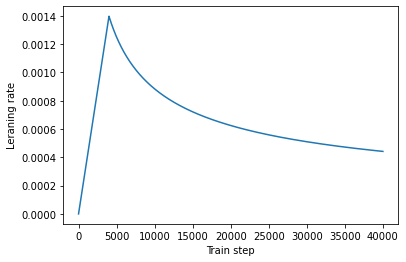

In [44]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)
#下面是学习率的设计图
plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Leraning rate")
plt.xlabel("Train step")

In [45]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = 'none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)


In [46]:
def create_masks(inp, tar):
    """
    Encoder:
      - encoder_padding_mask (self attention of EncoderLayer)
      对于encoder中padding值没作用，所以无需attention
    Decoder:
      - look_ahead_mask (self attention of DecoderLayer)
      target位置上的词不能看到之后的词，因为之后的词没预测出来
      - encoder_decoder_padding_mask (encoder-decoder attention of DecoderLayer)
      decoder不应该到encoder的padding上去花费精力
      - decoder_padding_mask (self attention of DecoderLayer)
      decoder也有padding，所以mask掉
    """
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    decoder_mask = tf.maximum(decoder_padding_mask,
                              look_ahead_mask)
    
    print( encoder_padding_mask.shape )
    print( encoder_decoder_padding_mask.shape )
    print( look_ahead_mask.shape )
    print( decoder_padding_mask.shape )
    print( decoder_mask.shape )

    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [47]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

In [48]:
print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)
#样本大小是64，不足的补齐35，或者39
#最后是(64, 1, 39, 39)原因是既不关注前面的padding，也不关注后面的单词

(64, 37)
(64, 38)
(64, 1, 1, 37)
(64, 1, 1, 37)
(38, 38)
(64, 1, 1, 38)
(64, 1, 38, 38)


(<tf.Tensor: shape=(64, 1, 1, 37), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(64, 1, 38, 38), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.

In [ ]:
train_loss = keras.metrics.Mean(name = 'train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(
    name = 'train_accuracy')

@tf.function
def train_step(inp, tar):
    tar_inp  = tar[:, :-1]  #没带end
    tar_real = tar[:, 1:]   #没有start
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)
#一个epochs接近90秒
epochs = 20
for epoch in range(epochs):
    start = time.time()
    #reset后就会从零开始累计
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(),
                train_accuracy.result()))
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result()))
    print('Time take for 1 epoch: {} secs\n'.format(
        time.time() - start))

#loss是一个正常的指标，accuracy只是机器翻译的一个参考指标，可以看趋势
    

(64, 1, 1, 40)
(64, 1, 1, 40)
(39, 39)
(64, 1, 1, 39)
(64, 1, 39, 39)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
-----------------------------------------------

(64, 1, 1, 40)
(64, 1, 1, 40)
(37, 37)
(64, 1, 1, 37)
(64, 1, 37, 37)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
-----------------------------------------------

(64, 1, 1, 34)
(64, 1, 1, 34)
(37, 37)
(64, 1, 1, 37)
(64, 1, 37, 37)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
-----------------------------------------------

(64, 1, 1, 38)
(64, 1, 1, 38)
(37, 37)
(64, 1, 1, 37)
(64, 1, 37, 37)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
-----------------------------------------------

(64, 1, 1, 39)
(64, 1, 1, 39)
(37, 37)
(64, 1, 1, 37)
(64, 1, 37, 37)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
-----------------------------------------------

(64, 1, 1, 39)
(64, 1, 1, 39)
(36, 36)
(64, 1, 1, 36)
(64, 1, 36, 36)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
-----------------------------------------------

(64, 1, 1, 35)
(64, 1, 1, 35)
(36, 36)
(64, 1, 1, 36)
(64, 1, 36, 36)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
-----------------------------------------------

(64, 1, 1, 39)
(64, 1, 1, 39)
(38, 38)
(64, 1, 1, 38)
(64, 1, 38, 38)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
-----------------------------------------------

(64, 1, 1, 40)
(64, 1, 1, 40)
(36, 36)
(64, 1, 1, 36)
(64, 1, 36, 36)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
-----------------------------------------------

(64, 1, 1, 40)
(64, 1, 1, 40)
(34, 34)
(64, 1, 1, 34)
(64, 1, 34, 34)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
-----------------------------------------------

(64, 1, 1, 39)
(64, 1, 1, 39)
(35, 35)
(64, 1, 1, 35)
(64, 1, 35, 35)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
-----------------------------------------------

(64, 1, 1, 37)
(64, 1, 1, 37)
(35, 35)
(64, 1, 1, 35)
(64, 1, 35, 35)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
-----------------------------------------------

(64, 1, 1, 37)
(64, 1, 1, 37)
(37, 37)
(64, 1, 1, 37)
(64, 1, 37, 37)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
-----------------------------------------------

(64, 1, 1, 37)
(64, 1, 1, 37)
(39, 39)
(64, 1, 1, 39)
(64, 1, 39, 39)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
-----------------------------------------------

(64, 1, 1, 38)
(64, 1, 1, 38)
(35, 35)
(64, 1, 1, 35)
(64, 1, 35, 35)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
-----------------------------------------------

(64, 1, 1, 38)
(64, 1, 1, 38)
(36, 36)
(64, 1, 1, 36)
(64, 1, 36, 36)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
-----------------------------------------------

(64, 1, 1, 33)
(64, 1, 1, 33)
(37, 37)
(64, 1, 1, 37)
(64, 1, 37, 37)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
--------------------------------------------------
(64, 37, 128)
(64, 37, 128)
-----------------------------------------------

(64, 1, 1, 32)
(64, 1, 1, 32)
(34, 34)
(64, 1, 1, 34)
(64, 1, 34, 34)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
-----------------------------------------------

(64, 1, 1, 36)
(64, 1, 1, 36)
(39, 39)
(64, 1, 1, 39)
(64, 1, 39, 39)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
-----------------------------------------------

(64, 1, 1, 39)
(64, 1, 1, 39)
(34, 34)
(64, 1, 1, 34)
(64, 1, 34, 34)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
-----------------------------------------------

(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 34, 128)
--------------------------------------------------
(64, 34, 128)
(64, 1, 1, 33)
(64, 1, 1, 33)
(34, 34)
(64, 1, 1, 34)
(64, 1, 34, 34)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
-----------------------------------------------

(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 1, 1, 38)
(64, 1, 1, 38)
(33, 33)
(64, 1, 1, 33)
(64, 1, 33, 33)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 38, 128)
--------------------------------------------------
(64, 38, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
-----------------------------------------------

(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 1, 1, 39)
(64, 1, 1, 39)
(32, 32)
(64, 1, 1, 32)
(64, 1, 32, 32)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 39, 128)
--------------------------------------------------
(64, 39, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
-----------------------------------------------

(64, 1, 1, 40)
(64, 1, 1, 40)
(33, 33)
(64, 1, 1, 33)
(64, 1, 33, 33)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
--------------------------------------------------
(64, 33, 128)
(64, 33, 128)
-----------------------------------------------

Epoch 2 Batch 500 Loss 2.4125 Accuracy 0.1203
(64, 1, 1, 36)
(64, 1, 1, 36)
(31, 31)
(64, 1, 1, 31)
(64, 1, 31, 31)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
-

(64, 1, 1, 36)
(64, 1, 1, 36)
(32, 32)
(64, 1, 1, 32)
(64, 1, 32, 32)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 36, 128)
--------------------------------------------------
(64, 36, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
-----------------------------------------------

(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 35, 128)
--------------------------------------------------
(64, 35, 128)
(64, 1, 1, 40)
(64, 1, 1, 40)
(30, 30)
(64, 1, 1, 30)
(64, 1, 30, 30)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 40, 128)
--------------------------------------------------
(64, 40, 128)
(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 30, 128)
-----------------------------------------------

Epoch 6 Loss 1.4606 Accuracy 0.2264
Time take for 1 epoch: 439.66043972969055 secs

Epoch 7 Batch 0 Loss 1.2945 Accuracy 0.2549
Epoch 7 Batch 100 Loss 1.2991 Accuracy 0.2438
Epoch 7 Batch 200 Loss 1.3040 Accuracy 0.2445
Epoch 7 Batch 300 Loss 1.2992 Accuracy 0.2447
Epoch 7 Batch 400 Loss 1.2955 Accuracy 0.2456
Epoch 7 Batch 500 Loss 1.2875 Accuracy 0.2459
Epoch 7 Batch 600 Loss 1.2814 Accuracy 0.2465
Epoch 7 Batch 700 Loss 1.2748 Accuracy 0.2469
(31, 1, 1, 37)
(31, 1, 1, 37)
(38, 38)
(31, 1, 1, 38)
(31, 1, 38, 38)
(31, 37, 128)
--------------------------------------------------
(31, 37, 128)
(31, 37, 128)
--------------------------------------------------
(31, 37, 128)
(31, 37, 128)
--------------------------------------------------
(31, 37, 128)
(31, 37, 128)
--------------------------------------------------
(31, 37, 128)
(31, 38, 128)
--------------------------------------------------
(31, 38, 128)
(31, 38, 128)
--------------------------------------------------
(31, 38, 128)
(31, 3

(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
Epoch 10 Batch 300 Loss 0.9259 Accuracy 0.2911
(64, 1, 1, 31)
(64, 1, 1, 31)
(30, 30)
(64, 1, 1, 30)
(64, 1, 30, 30)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 31, 128)
--------------------------------------------------
(64, 31, 128)
(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 30, 128)
--------------------------------------------------
(64, 30, 128)
(64, 30, 128)


Epoch 12 Batch 100 Loss 0.7875 Accuracy 0.3112
Epoch 12 Batch 200 Loss 0.7893 Accuracy 0.3095
Epoch 12 Batch 300 Loss 0.7977 Accuracy 0.3079
Epoch 12 Batch 400 Loss 0.8018 Accuracy 0.3075
Epoch 12 Batch 500 Loss 0.8063 Accuracy 0.3077
(64, 1, 1, 32)
(64, 1, 1, 32)
(28, 28)
(64, 1, 1, 28)
(64, 1, 28, 28)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 32, 128)
--------------------------------------------------
(64, 32, 128)
(64, 28, 128)
--------------------------------------------------
(64, 28, 128)
(64, 28, 128)
--------------------------------------------------
(64, 28, 128)
(64, 28, 128)
--------------------------------------------------
(64, 28, 128)
(64, 28, 128)
--------------------------------------------------
(64, 28, 128)
(64, 28, 128)
-------------------------------------------------

--------------------------------------------------
(31, 36, 128)
(31, 36, 128)
--------------------------------------------------
(31, 36, 128)
(31, 36, 128)
--------------------------------------------------
(31, 36, 128)
(31, 36, 128)
--------------------------------------------------
(31, 36, 128)
(31, 36, 128)
--------------------------------------------------
(31, 36, 128)
(31, 36, 128)
--------------------------------------------------
(31, 36, 128)
Epoch 15 Loss 0.6885 Accuracy 0.3233
Time take for 1 epoch: 444.9080696105957 secs

Epoch 16 Batch 0 Loss 0.6709 Accuracy 0.3181
Epoch 16 Batch 100 Loss 0.6123 Accuracy 0.3341
Epoch 16 Batch 200 Loss 0.6272 Accuracy 0.3331
Epoch 16 Batch 300 Loss 0.6358 Accuracy 0.3320
Epoch 16 Batch 400 Loss 0.6409 Accuracy 0.3306
Epoch 16 Batch 500 Loss 0.6465 Accuracy 0.3292
Epoch 16 Batch 600 Loss 0.6517 Accuracy 0.3285
(64, 1, 1, 36)
(64, 1, 1, 36)
(29, 29)
(64, 1, 1, 29)
(64, 1, 29, 29)
(64, 36, 128)
---------------------------------------------

(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
(64, 29, 128)
--------------------------------------------------
(64, 29, 128)
Epoch 19 Batch 100 Loss 0.5490 Accuracy 0.3471
Epoch 19 Batch 200 Loss 0.5533 Accuracy 0.3452
(64, 1, 1, 32)
(64, 1, 1, 32)
(27, 27)
(64, 1, 1, 27)
(64, 1, 27, 27)
(64, 32, 128)
--------------------------------

In [ ]:
"""
eg: A B C D -> E F G H.
Train: A B C D, E F G -> F G H
Eval:  A B C D -> E
       A B C D, E -> F
       A B C D, E F -> G
       A B C D, E F G -> H
类似seq2seq2
不同的是 transformer可以并行的处理，前后没有依赖，而seq2seq前后有依赖
"""
def evaluate(inp_sentence):
    #文本的句子转换为id的句子
    input_id_sentence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    #transformer转换是两维的，因此转换
    # encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # decoder_input.shape: (1, 1)
    #我们预测一个词就放入decoder_input，decoder_input给多个就可以预测多个，我们给一个
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        #产生mask并传给transformer
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # predictions.shape: (batch_size, target_vocab_size)
        #我们每次只预测一个，所以是最后一个
        predictions = predictions[:, -1, :]
        #预测值就是概率最大的那个的索引
        predicted_id = tf.cast(tf.argmax(predictions, axis = -1),
                               tf.int32)
        #如果等于end id，预测结束
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        #如果predicted_id不是end id，添加到新的decoder_input中
        decoder_input = tf.concat([decoder_input, [predicted_id]],
                                  axis = -1)
    return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        

In [ ]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    fig = plt.figure(figsize = (16, 8))
    
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        
        ax.matshow(attention[head][:-1, :])
        
        fontdict = {'fontsize': 10}
        
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result) - 1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict = fontdict, rotation = 90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict = fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()      

In [ ]:
def translate(input_sentence, layer_name = ''):
    result, attention_weights = evaluate(input_sentence)
    
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                       result, layer_name)

In [ ]:
translate('está muito frio aqui.')

In [ ]:
translate('isto é minha vida')

In [ ]:
translate('você ainda está em casa?')

In [ ]:
translate('este é o primeiro livro que eu já li')

In [ ]:
translate('este é o primeiro livro que eu já li',
          layer_name = 'decoder_layer4_att2')